# Overview:

## Get instantaneous sensitivities

In [1]:
import sensitivity_calculator as sens
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# t_filter_cold and feedhorn beam file used for spill calculations should be refined further.

inputs = {'diameter': 5.7, 't': 273, 'wfe': 10.7, 'eta': 0.98, 'doe': 0.8, 't_int': 1, 'pixelYield': 0.8, 
        'szCamNumPoln': 1, 'eorSpecNumPoln': 2, 't_filter_cold': np.array([0.593, 0.84 , 0.909, 0.922, 0.89 ]), 
        't_lens_cold': np.array([0.98, 0.98, 0.98, 0.98, 0.98]), 
        't_uhdpe_window': np.array([0.96, 0.97, 0.97, 0.97, 0.97]), 
        'singleModedAOmegaLambda2': np.array([1., 1., 1., 1., 1.]), 
        'spatialPixels': np.array([39762, 20808, 10368, 10368,  7938]), 
        'eqbw': np.array([9.7e+10, 3.0e+10, 3.6e+10, 7.0e+10, 5.6e+10]), 
        'centerFrequency': np.array([8.50e+11, 4.05e+11, 3.48e+11, 2.85e+11, 2.22e+11]), 'detectorNEP': 0, 
        'backgroundSubtractionDegradationFactor': 1, 'r': np.array([[100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.],
                                            [100., 100., 100.]]), 
        'decimalPlaces': 3, 'observationElevationAngle': 55, 'outputFreq': True, 
        'detectorSpacing': np.array([1.45, 1.97, 2.75, 2.75, 3.13]), 'lyotStopAngle': 13.4}
# Alternatively, sens.getInputs("input.yaml")

spillEfficiency = sens.getSpillEfficiency(inputs, oldFile=True)
calculate = sens.calcByAngle(inputs["diameter"], inputs["t"], inputs["wfe"], inputs["eta"], inputs["doe"], inputs["t_int"], inputs["pixelYield"], inputs["szCamNumPoln"], inputs["eorSpecNumPoln"],
                            inputs["t_filter_cold"], inputs["t_lens_cold"], inputs["t_uhdpe_window"], spillEfficiency, inputs["singleModedAOmegaLambda2"],
                            inputs["spatialPixels"], inputs["eqbw"], inputs["centerFrequency"], inputs["detectorNEP"],
                            inputs["backgroundSubtractionDegradationFactor"], inputs["r"])

outputs = calculate(90-inputs['observationElevationAngle'])

print("FOR FREQUENCIES:",inputs['centerFrequency'])
print('spill efficiency:',spillEfficiency)
print("beam [arcsec]: ", outputs["beam"])
print("NEP weighted avrage [uK_CMB rt(s)]: ", outputs['netW8Avg'])
print("Transmission (three quartiles): ", outputs['EqTrans'])

FOR FREQUENCIES: [8.50e+11 4.05e+11 3.48e+11 2.85e+11 2.22e+11]
spill efficiency: [0.76390292 0.49038857 0.60958542 0.47873857 0.40693271]
beam [arcsec]:  [15.31558919 32.14382916 37.4087667  45.67807302 58.64076942]
NEP weighted avrage [uK_CMB rt(s)]:  [1.44881597e+05 1.62675128e+02 5.49408052e+01 1.28278173e+01
 7.24048448e+00]
Transmission (three quartiles):  [[0.49283484 0.32024658 0.13742443]
 [0.80854761 0.71933073 0.57219447]
 [0.89220249 0.83712163 0.73817139]
 [0.94749661 0.92341975 0.87747277]
 [0.96556221 0.95151083 0.92402585]]


## Get integrated noise curves for GAMA-9

f_sky: 0.003996157155846102
sky_area: 164.85331629670875
pseudo-Cl PS correction factor 0.003288783903506914


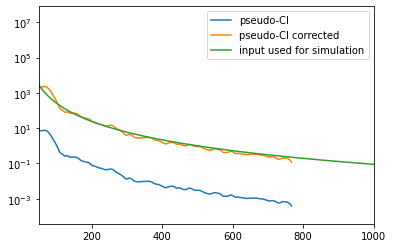

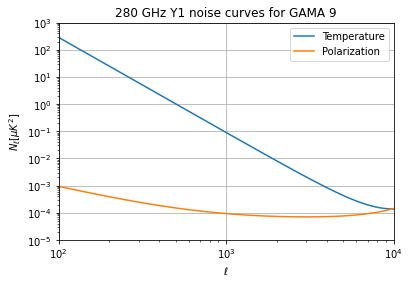

In [2]:
survey_hours = 79.4
el = inputs['observationElevationAngle']

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

seed = 0
np.random.seed(seed)
NSIDE = 256
hitmap_path = "src/sensitivity_calculator/data/gama9_hit_map_healpix_nside" + str(NSIDE) + "_231218.fits"

hitmap = hp.read_map(hitmap_path)
hitmap /= np.max(hitmap)

fsky = get_hivon_fsky(hitmap)
sky_area = fsky*4*np.pi*(180/np.pi)**2

print("f_sky:", fsky)
print("sky_area:", sky_area)

# calculate noise curves
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs, 
                                                      survey_hours = survey_hours, el = el,
                                                      sky_area = sky_area, atmosphere=True)

# Calculate a naive multiplicative factor for correcting pseudo-Cl power spectra calculated below.
N_ell_T_full[3,:2] = 0

tmp_m = hp.synfast(N_ell_T_full[3],nside=NSIDE)
tmp_nl = hp.anafast(tmp_m*hitmap)
fac_gama = np.mean(tmp_nl[2:]/N_ell_T_full[3,2:len(tmp_nl)])
print("pseudo-Cl PS correction factor", fac_gama)

# check PS correction factor
plt.plot(tmp_nl, label='pseudo-Cl')
plt.plot(tmp_nl/fac_gama, label='pseudo-Cl corrected')
plt.plot(N_ell_T_full[3], label='input used for simulation')
plt.yscale('log')
plt.xlim(50,1000)
plt.legend()
plt.show()

# plot 280 GHz noise curves for GAMA-9
plt.plot(ell, N_ell_T_full[3], label='Temperature')
plt.plot(ell, N_ell_P_full[3], label='Polarization')
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell [\mu K^2]$')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**2, 10**4)
plt.ylim(1e-5,1e3)
plt.title('280 GHz Y1 noise curves for GAMA 9')
plt.grid()
plt.show()


## GAMA-9 noise simulations

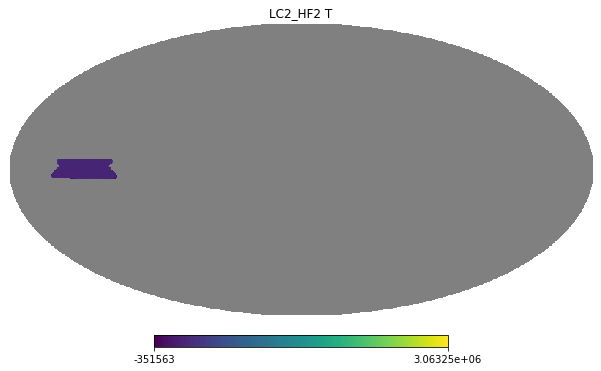

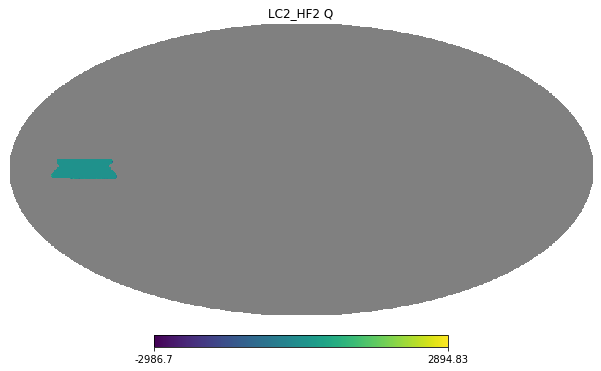

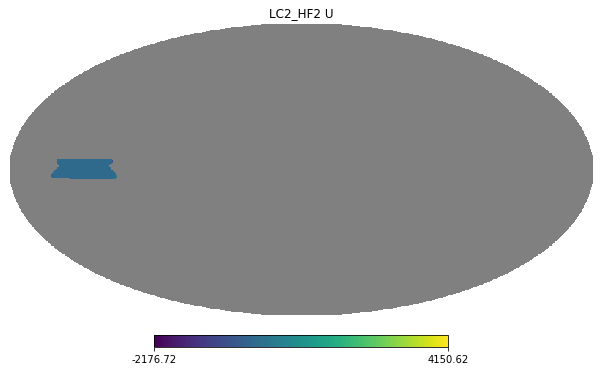

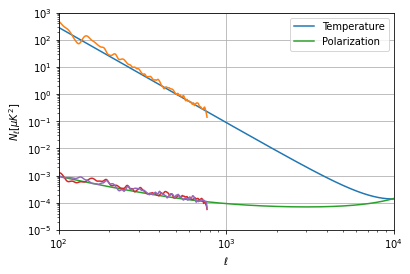

In [3]:
data_C = sens.sensitivity._data_C_calcV2(inputs)

# band/tube/frequency [GHz]
# HF1  LC1            222.0
# HF2  LC2            280.0
# HF3  LC3            348.0
# HF4  LC4            405.0
# HF5  LC5            850.0

pysm_components = None
sim_noise = True

ccat280 = sens.ccat_mapsims(
    inputs, outputs, "HF2", "LC2", pysm_components, seed, data_C, sim_cmb=False, 
    sim_noise=sim_noise, NSIDE=NSIDE, survey_hours=survey_hours, el=el, hitmap_path=hitmap_path)

ccat280cls = hp.sphtfunc.anafast(ccat280*hitmap)/fac_gama

plt.plot(ell, N_ell_T_full[3], label='Temperature')
plt.plot(ell[:len(ccat280cls[0])], ccat280cls[0])
plt.plot(ell, N_ell_P_full[3], label='Polarization')
plt.plot(ell[:len(ccat280cls[1])], ccat280cls[1])
plt.plot(ell[:len(ccat280cls[2])], ccat280cls[2])
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell [\mu K^2]$')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**2, 10**4)
plt.ylim(1e-5,1e3)
plt.grid()
plt.show()

## Get integrated noise curves for DEEP56

f_sky: 0.01900697640552113
sky_area: 784.0940611255895
pseudo-Cl PS correction factor 0.012347936483559563


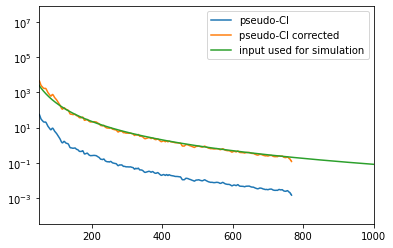

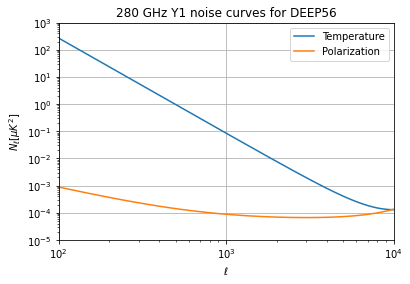

In [4]:
survey_hours = 400.
el = inputs['observationElevationAngle']

def get_hivon_fsky(mask):
    npix = len(mask)
    non0 = np.where(mask!=0)[0]
    fs = len(non0)/float(npix)
    w2 = np.sum(mask[non0]**2)/(npix*fs)
    w4 = np.sum(mask[non0]**4)/(npix*fs)
    return fs*w2**2/w4

seed = 0
np.random.seed(seed)
NSIDE = 256
hitmap_path = "src/sensitivity_calculator/data/deep56_hit_map_healpix_nside" + str(NSIDE) + "_231218.fits"

hitmap = hp.read_map(hitmap_path)
hitmap /= np.max(hitmap)

fsky = get_hivon_fsky(hitmap)
sky_area = fsky*4*np.pi*(180/np.pi)**2

print("f_sky:", fsky)
print("sky_area:", sky_area)

# calculate noise curves
ell, N_ell_T_full, N_ell_P_full = sens.getNoiseCurves(inputs, outputs, 
                                                      survey_hours = survey_hours, el = el,
                                                      sky_area = sky_area, atmosphere=True)

# Calculate a naive multiplicative factor for correcting pseudo-Cl power spectra calculated below.
N_ell_T_full[3,:2] = 0

tmp_m = hp.synfast(N_ell_T_full[3],nside=NSIDE)
tmp_nl = hp.anafast(tmp_m*hitmap)
fac_deep56 = np.mean(tmp_nl[2:]/N_ell_T_full[3,2:len(tmp_nl)])
print("pseudo-Cl PS correction factor", fac_deep56)

# check PS correction factor
plt.plot(tmp_nl, label='pseudo-Cl')
plt.plot(tmp_nl/fac_deep56, label='pseudo-Cl corrected')
plt.plot(N_ell_T_full[3], label='input used for simulation')
plt.yscale('log')
plt.xlim(50,1000)
plt.legend()
plt.show()

# plot 280 GHz noise curves for DEEP56
plt.plot(ell, N_ell_T_full[3], label='Temperature')
plt.plot(ell, N_ell_P_full[3], label='Polarization')
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell [\mu K^2]$')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**2, 10**4)
plt.ylim(1e-5,1e3)
plt.title('280 GHz Y1 noise curves for DEEP56')
plt.grid()
plt.show()

## DEEP56 noise simulations

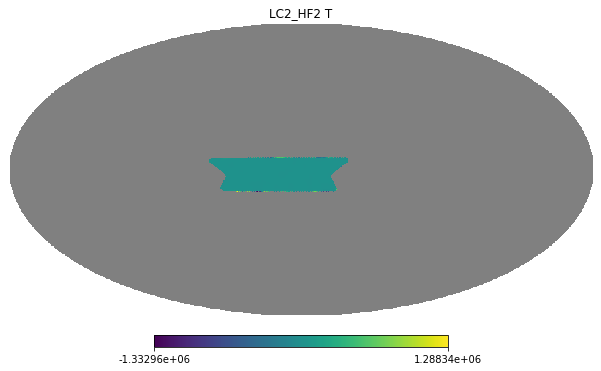

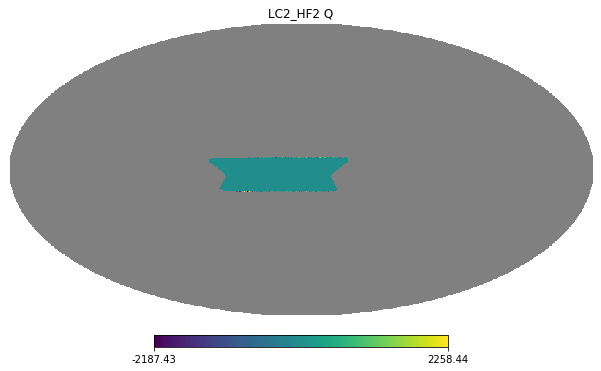

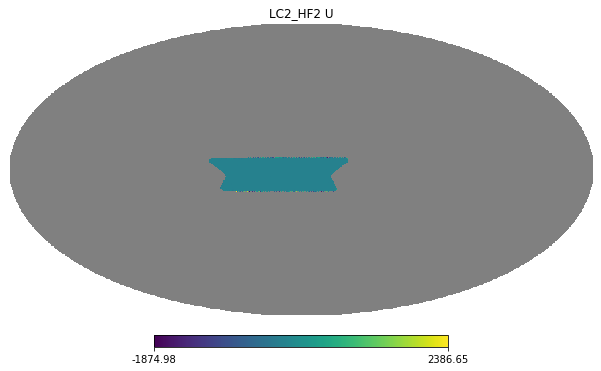

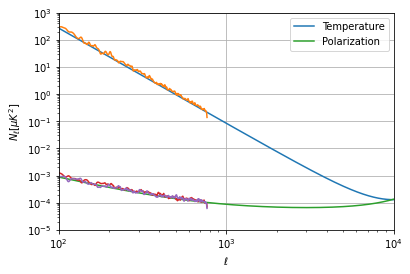

In [5]:
data_C = sens.sensitivity._data_C_calcV2(inputs)

# band/tube/frequency [GHz]
# HF1  LC1            222.0
# HF2  LC2            280.0
# HF3  LC3            348.0
# HF4  LC4            405.0
# HF5  LC5            850.0

pysm_components = None
sim_noise = True

ccat280 = sens.ccat_mapsims(
    inputs, outputs, "HF2", "LC2", pysm_components, seed, data_C, sim_cmb=False, 
    sim_noise=sim_noise, NSIDE=NSIDE, survey_hours=survey_hours, el=el, hitmap_path=hitmap_path)

ccat280cls = hp.sphtfunc.anafast(ccat280*hitmap)/fac_deep56

plt.plot(ell, N_ell_T_full[3], label='Temperature')
plt.plot(ell[:len(ccat280cls[0])], ccat280cls[0])
plt.plot(ell, N_ell_P_full[3], label='Polarization')
plt.plot(ell[:len(ccat280cls[1])], ccat280cls[1])
plt.plot(ell[:len(ccat280cls[2])], ccat280cls[2])
plt.xlabel('$\ell$')
plt.ylabel('$N_\ell [\mu K^2]$')
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlim(10**2, 10**4)
plt.ylim(1e-5,1e3)
plt.grid()
plt.show()